### CSV Data Export
Data for all products, or some of the products, can be downloaded in CSV format (readable with OpenOffice, Excel and many other software) through the advanced search form.

### Link
https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv
The file encoding is Unicode UTF-8. The character that separates fields is <tab> (tabulation).

**or**
    
http://fr.openfoodfacts.org/data/fr.openfoodfacts.org.products.csv for France products

In [117]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Library for ignoring warnings
import warnings
warnings.filterwarnings("ignore")

# Functions

In [75]:
# Function to reduce memory usage:
def reduce_memory_usage(df):
    # Print memory usage before changing datatypes
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage before: {:.2f} MB'.format(start_mem))
    
    # Change datatypes
    for col in df.columns:
        col_type = df[col].dtype
        
        # Change datatypes only for integers or floats
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            # Change datatypes for integers
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                    
            # Change datatypes for floats
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    
    # Print memory usage after changing datatypes
    end_mem = df.memory_usage().sum() / 1024**2 
    print('Memory usage now : {:.2f} MB'.format(end_mem)) 
    print('Memory usage decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
# Function to display all the columns and rows
def set_pandas_display_options() -> None:
    display = pd.options.display
    display.max_columns = 200
    display.max_rows = 200
    display.max_colwidth = 200
    display.width = None

# Create a function allowing to select useful columns 
# for the application "eat better, eat healthy" via a list of columns
def filter_columns(df, list_columns):
    df = df[list_columns]
    
    return df

# Create a function to filter the dataframe by country
def filter_country(df, country):
    df = df.loc[df["countries_fr"].str.contains(country, na=False)]
    
    return df

# Create a function to remove rows containing NaNs 
# by selecting certain columns only
def delete_NaN(df, col_list):
    df = df.dropna(subset = col_list)
    
    return df

# Create a function to remove rows containing
# outliers (> 100 and < 0) for a selection of columns
def remove_outlier(df, col_list):
    for col in col_list:
        filtre = df[(df[col] > 100) | (df[col] < 0)].index
        df = df.drop(filtre)
        
    return(df)

# Creation of a function for deleting aberrant lines
# (sum of nutrients > 100g for a 100g portion)
def remove_outliers_rows(df, list_columns_to_sum):
    for list_col in list_columns_to_sum:
        df = df.loc[(df[list_col].sum(axis=1)) <=100]

    return df

# Create a function to remove rows containing
# outliers (> 3807) for the "energy_100g" variable
def remove_outlier_energy(df):
    filtre = df[df['energy_100g'] > 3807].index
    df = df.drop(filtre)
    return df

# Creating a function to remove 'code' duplicates
def remove_duplicates(df):
    # we count the number of missing values per line, 
    # to know which duplicate to delete
    # and we store the deleted data in a new column
    df['NB_NAN'] = df.isna().sum(axis=1)
    # we sort in ascending order the rows according 
    # to the number of missing values (using the new column created)
    df = df.sort_values('NB_NAN')
    # removal of duplicates keeping the most filled versions
    df = df.drop_duplicates('code', keep='first')
    # we delete the column that is no longer useful
    df = df.drop('NB_NAN', axis=1)
    return df

# As above, we assign the correct categories "Unsweetened beverages"
# or "Artificially sweetened beverages" instead of "Alcoholic beverages"
# for pnns_groups_2
def alcoholic_to_unalcoholic(df):
    df['pnns_groups_2'].loc[(df['pnns_groups_2'] == 'Alcoholic beverages')
                            & (df['sugars_100g'] > 10)] = 'Artificially sweetened beverages'
    df['pnns_groups_2'].loc[(df['pnns_groups_2'] == 'Alcoholic beverages')
                            & (df['sugars_100g'] < 10)] = 'Unsweetened beverages'
    return df

# Create a function to display boxplot 
# with categories sorted by ascending values of median
def display_boxplot_sorted_median(df, x, y):
    order = df.groupby(y)[x].median().sort_values().index

    plt.figure(figsize=(12,13))
    sns.boxplot(x=x, y=y,
                showfliers=True, # Display outliers
                orient='h',
                order=order,
                data=df,
                showmeans=True) # Show the mean of each category

    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlabel(x, size=15)
    plt.ylabel(y, size=15)

    plt.title(f"{x} by {y}", fontsize=16);

# Function to replace 'unknown' with pnns_groups_2
def replace_unknown_by_pnns_2(df):
    # We save the position index of the column "pnns_groups_2"
    index_pnns_2 = df.columns.get_loc("pnns_groups_2")
    # We use the position index of list_pnns_groups_2
    for i in range(len(pnns_2)):
        # We save the list of line indices for which we have 
        # a match main_category/pnns_groups_2
        index_list = df.index[(df['main_category_fr'].isin(
            (list(main_category_by_pnns_2.values())[i])
        ))].tolist()
        for row_index in index_list:
            # If 'unknown' is contained in the column, 
            # it is replaced by the pnns_groups_2 corresponding to the main_category
            if df.iloc[row_index,index_pnns_2] == 'unknown':
                df.iloc[row_index,index_pnns_2] = df.iloc[row_index,index_pnns_2].replace('unknown', pnns_2[i])
            # If a pnns_groups_2 is already assigned, nothing is changed
            else:
                continue
    return df

# Function to replace 'unknown' with pnns_groups_1
def replace_unknown_by_pnns_1(df):
    # Get the position index of the "pnns_groups_1" column
    index_pnns_1 = df.columns.get_loc("pnns_groups_1")
    for i in range(len(pnns_1)):
        # Get the list of indices for which we have a match 
        # pnns_groups_2/pnns_groups_1
        index_list = df.index[(df['pnns_groups_2'].isin(
            (list(pnns_2_by_pnns_1.values())[i])
        ))].tolist()
        for row_index in index_list:
            if df.iloc[row_index,index_pnns_1] == 'unknown':
                df.iloc[row_index,index_pnns_1] = df.iloc[row_index,index_pnns_1].replace('unknown', pnns_1[i])
            else:
                continue
    return df

# Function to replace NaN values
# of the different nutrition or energy columns
# by the median of each column by pnns_group_2
def replace_NaN_by_median_pnns_2(df):
    for col in columns_median:
        # indexing the columns of the list defined above
        index_col = df.columns.get_loc(col)
        # index rows containing NaNs for columns in the list above
        index_row_nan = df.loc[df[col].isna()].index
        for i in range(len(pnns_2)):
            # Median calculation for each column and each category pnns_groups_2
            # (not counting NaN)
            median = df[col].loc[df['pnns_groups_2'] == pnns_2[i]].median(skipna=True)
            # Assignment of the median value instead of the corresponding NaN
            df.iloc[index_row_nan, index_col] = median
    return df

# Read the dataset 'openfoodfacts'

In [3]:
# Read the dataset
openfoodfacts = pd.read_csv(
    "C:/Users/33624/Downloads/fr.openfoodfacts.org.products.csv", 
    sep='\t',
    encoding='utf-8'
)

In [4]:
# Reduce the memory usage of dataset openfoodfacts
# by optmizing datatypes
reduce_memory_usage(openfoodfacts)

Memory usage before: 3621.30 MB
Memory usage now : 2044.28 MB
Memory usage decreased by 43.5%


In [5]:
openfoodfacts.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,00000000000000225,http://world-fr.openfoodfacts.org/produit/0000...,nutrinet-sante,1623855208,2021-06-16T14:53:28Z,1623855209,2021-06-16T14:53:29Z,jeunes pousses,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000000207025004,http://world-fr.openfoodfacts.org/produit/0000...,kiliweb,1656948610,2022-07-04T15:30:10Z,1656948613,2022-07-04T15:30:13Z,Andrè,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00000000000003429145,http://world-fr.openfoodfacts.org/produit/0000...,kiliweb,1630483911,2021-09-01T08:11:51Z,1656488106,2022-06-29T07:35:06Z,L.casei,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00000000000026772226,http://world-fr.openfoodfacts.org/produit/0000...,kiliweb,1654250311,2022-06-03T09:58:31Z,1654270474,2022-06-03T15:34:34Z,Skyr,NaN,NaN,...,NaN,-5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000000017,http://world-fr.openfoodfacts.org/produit/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Exploratory Data Analysis

## Form Analysis

In [6]:
# Print informations about dataset insurance
openfoodfacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2551889 entries, 0 to 2551888
Columns: 186 entries, code to carnitine_100g
dtypes: float16(90), float32(25), float64(6), int32(2), object(63)
memory usage: 2.0+ GB


In [8]:
# Display all the columns and rows of dataset openfoodfacts
set_pandas_display_options()

In [9]:
# Shape of the datasets
print(f'openfoodfacts dataset contains {openfoodfacts.shape[0]} records and {openfoodfacts.shape[1]} columns.')

openfoodfacts dataset contains 2551889 records and 186 columns.


In [10]:
# Types of features
openfoodfacts.dtypes.value_counts()

float16    90
object     63
float32    25
float64     6
int32       2
dtype: int64

In [11]:
# Number of duplicated records in dataset 'openfoodfacts'
print('Number of duplicates in openfoodfacts dataset:', 
      openfoodfacts.duplicated().sum())

Number of duplicates in openfoodfacts dataset: 3


In [12]:
# Drop the duplicated row from dataset 'openfoodfacts'
openfoodfacts = openfoodfacts.drop(
    openfoodfacts[openfoodfacts.duplicated()].index
)

In [13]:
# Missing values in the dataset 'openfoodfacts' ?
print('openfoodfacts NaNs')
print('*'*20)
print(openfoodfacts.isna().mean().sort_values())

openfoodfacts NaNs
********************
code                                                     0.000000
url                                                      0.000000
created_t                                                0.000000
created_datetime                                         0.000000
last_modified_t                                          0.000000
last_modified_datetime                                   0.000000
states                                                   0.000000
states_tags                                              0.000000
states_fr                                                0.000000
creator                                                  0.000002
pnns_groups_2                                            0.001891
pnns_groups_1                                            0.001892
ecoscore_grade                                           0.002179
countries                                                0.002782
countries_tags                      

In [14]:
# Keep only columns with less than 80% of missing values
openfoodfacts = openfoodfacts[openfoodfacts.columns[openfoodfacts.isna().mean() < 0.8]]

In [15]:
# Shape of the updated dataframe
openfoodfacts.shape

(2551886, 55)

In [18]:
# Print new memory usage
print('New Memory usage: {:.2f} MB'.format(openfoodfacts.memory_usage().sum() / 1024**2))

New Memory usage: 895.59 MB


## Application Idea :

* **PureScore** :  
  -> **Eat better** (nutrients and energy),  
  -> **Eat unprocessed or less processed foods** (number of additives - not taken into account in nutriscore!),  
  -> **Eat foods with no or fewer additives** (nova group - not taken into account in nutriscore!)  
  
  
* **Variables needed by the application** :   
  -> url : to check certain products on a case-by-case basis 
  -> image_url : for the visual rendering of the app  
  -> product_name : for the visual rendering of the app  
  -> cetegories_fr, main_category_fr, pnns_groups_1 & pnns_groups_2 : to classify products and suggest alternatives by category  
  -> countries_fr : to filter products by country  
  -> **additives_n** : to calculate the **'additives' score**
  -> nutriscore_score, nutriscore_grade : to assess correlations with PureScore and other variables  
  -> **nova_group** : classification according to the degree of transformation of the product - to calculate the **'nova' score**  
  -> **energy, fat, saturated_fat, carbohydrates, sugars, proteins, salt, fiber, fruits_vegetables_nuts** : to calculate the **'nutrient' score**  
   
   
* **Considered scoring** :  rating / 10 overall  
  -> 3 points for score 'additives' 
  -> 3 points for score 'nova'  
  -> 4 points for score 'nutrients'    
  
  
* **Alternative products offered following the scan of a product** :   
  -> products belonging to more or less restricted groups with a higher PureScore than the scanned product
  

### Interest of the app : 
promote foods without additives and unprocessed (healthier) while taking into account the nutrients (which are taken into account in the calculation of the nutriscore)

## Cleaning

In [19]:
# Creating the list of retained columns for the application
columns_application = [
    'code', 'url','image_url', 'product_name', 'categories_fr',
    'countries_fr', 'additives_n', 'nutriscore_score', 'nutriscore_grade',
    'nova_group', 'pnns_groups_1', 'pnns_groups_2', 'main_category_fr',
    'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
    'sugars_100g', 'proteins_100g', 'salt_100g', 'fiber_100g',
    'fruits-vegetables-nuts-estimate-from-ingredients_100g'
]

In [21]:
# Filter the dataset openfoodfact by keeping only the retained columns
openfoodfacts = filter_columns(openfoodfacts, columns_application)

In [25]:
# The dashes "-" are replaced by underscores "_" 
# in the column names of the variables concerned
openfoodfacts = openfoodfacts.rename(
    columns={
        'saturated-fat_100g': 'saturated_fat_100g',
        'fruits-vegetables-nuts-estimate-from-ingredients_100g':
        'fruits_vegetables_nuts_estimate_from_ingredients_100g'
    }
)

### Filter dataset by country 'France'

In [27]:
# Select only data for France
openfoodfacts = filter_country(openfoodfacts, "France")

In [30]:
# Save dataset after cleaning
openfoodfacts.to_csv(
    "openfoodfacts_filtered.csv",
    sep='\t',
    encoding='utf-8',
    index=False
)

### Delete NaN

In [128]:
openfoodfacts = pd.read_csv(
    "openfoodfacts_filtered.csv",
    sep='\t',
    encoding='utf-8'
)

In [130]:
# Create a list of columns necessary for the application 
# and for which the NaN cannot be replaced
not_alterable_columns = [
    'image_url', 'nova_group', 'additives_n', 'product_name',
    'nutriscore_grade', 'nutriscore_score', 'categories_fr',
    'main_category_fr'
]

In [131]:
# Remove rows containing NaNs that cannot be replaced
openfoodfacts = delete_NaN(openfoodfacts, not_alterable_columns)

In [132]:
# Shape of the dataset
openfoodfacts.shape

(169039, 22)

### Remove outliers

In [133]:
# Create a list containing all columns
# which must have values between 0 and 100
nutrition_columns = openfoodfacts.filter(regex='_100g').drop(['energy_100g'], axis=1).columns.tolist()

In [134]:
# Counting the number of individuals with values
# greater than 100g (outliers) for variables
# which must have values between 0 and 100
for col in nutrition_columns:
    print("- There is/are", 
          openfoodfacts.loc[openfoodfacts[col] > 100].shape[0], 
          "values greater than 100g in the column", 
          col)
    print("  -> i.e.",
          round(((openfoodfacts.loc[openfoodfacts[col] > 100].shape[0]) 
                 / openfoodfacts.shape[0] * 100), 4),
          "% of the total number of rows")
    print("-"*30)

- There is/are 4 values greater than 100g in the column fat_100g
  -> i.e. 0.0024 % of the total number of rows
------------------------------
- There is/are 8 values greater than 100g in the column saturated_fat_100g
  -> i.e. 0.0047 % of the total number of rows
------------------------------
- There is/are 16 values greater than 100g in the column carbohydrates_100g
  -> i.e. 0.0095 % of the total number of rows
------------------------------
- There is/are 5 values greater than 100g in the column sugars_100g
  -> i.e. 0.003 % of the total number of rows
------------------------------
- There is/are 4 values greater than 100g in the column proteins_100g
  -> i.e. 0.0024 % of the total number of rows
------------------------------
- There is/are 2 values greater than 100g in the column salt_100g
  -> i.e. 0.0012 % of the total number of rows
------------------------------
- There is/are 1 values greater than 100g in the column fiber_100g
  -> i.e. 0.0006 % of the total number of rows

In [135]:
# Counting the number of individuals with values
# smaller than 0g (outliers) for variables
# which must have values between 0 and 100
for col in nutrition_columns:
    print("- There is/are", 
          openfoodfacts.loc[openfoodfacts[col] < 0].shape[0], 
          "values smaller than 0g in the column", 
          col)
    print("  -> i.e.",
          round(((openfoodfacts.loc[openfoodfacts[col] < 0].shape[0]) 
                 / openfoodfacts.shape[0] * 100), 4),
          "% of the total number of rows")
    print("-"*30)

- There is/are 0 values smaller than 0g in the column fat_100g
  -> i.e. 0.0 % of the total number of rows
------------------------------
- There is/are 0 values smaller than 0g in the column saturated_fat_100g
  -> i.e. 0.0 % of the total number of rows
------------------------------
- There is/are 0 values smaller than 0g in the column carbohydrates_100g
  -> i.e. 0.0 % of the total number of rows
------------------------------
- There is/are 1 values smaller than 0g in the column sugars_100g
  -> i.e. 0.0006 % of the total number of rows
------------------------------
- There is/are 0 values smaller than 0g in the column proteins_100g
  -> i.e. 0.0 % of the total number of rows
------------------------------
- There is/are 0 values smaller than 0g in the column salt_100g
  -> i.e. 0.0 % of the total number of rows
------------------------------
- There is/are 0 values smaller than 0g in the column fiber_100g
  -> i.e. 0.0 % of the total number of rows
------------------------------


In [136]:
# Remove outliers in nutrition_columns
openfoodfacts = remove_outlier(openfoodfacts, nutrition_columns)

In [137]:
# Creating Lists of columns to sum
# to remove rows containing outliers
columns_to_sum_1 = [
    'saturated_fat_100g', 'sugars_100g', 'proteins_100g', 'salt_100g'
]

columns_to_sum_2 = [
    'fat_100g', 'sugars_100g', 'proteins_100g', 'salt_100g'
]

columns_to_sum_3 = [
    'fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g'
]

columns_to_sum_4 = [
    'saturated_fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g'
]

# Create a list of the above lists
list_columns_to_sum = [
    columns_to_sum_1, columns_to_sum_2, columns_to_sum_3, columns_to_sum_4
]

In [138]:
# Counting the number of products with values
# greater than 100g (outliers) for sums of variables
# which must be between 0 and 100
for col_sum in  list_columns_to_sum:
    print(f'number of products with values greater than 100g in {col_sum}')
    print(openfoodfacts.loc[(openfoodfacts[col_sum].sum(axis=1)) > 100].shape[0])
    print('-'*20)

number of products with values greater than 100g in ['saturated_fat_100g', 'sugars_100g', 'proteins_100g', 'salt_100g']
48
--------------------
number of products with values greater than 100g in ['fat_100g', 'sugars_100g', 'proteins_100g', 'salt_100g']
198
--------------------
number of products with values greater than 100g in ['fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g']
534
--------------------
number of products with values greater than 100g in ['saturated_fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g']
129
--------------------


In [139]:
# Remove rowns with aberrant sum values
openfoodfacts = remove_outliers_rows(
    openfoodfacts,
    list_columns_to_sum
)

In [140]:
# Find outliers for the "Energy" variable
# (expressed in kJ)
openfoodfacts['energy_100g'].describe()

count    167548.000000
mean       1135.625462
std         782.046831
min           0.000000
25%         464.850000
50%        1046.000000
75%        1678.000000
max       19305.000000
Name: energy_100g, dtype: float64

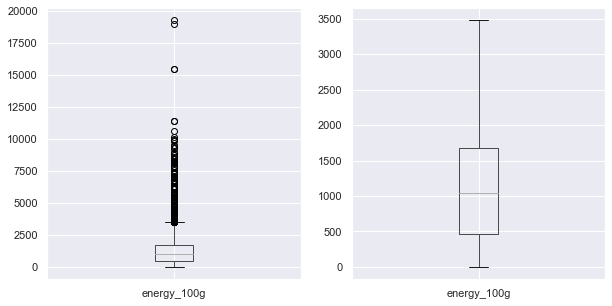

In [141]:
# Boxplot with or without outliers for energy_100g
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

sns.set_theme()
openfoodfacts.boxplot(column=["energy_100g"], ax=axes[0], showfliers=True)
openfoodfacts.boxplot(column=["energy_100g"], ax=axes[1], showfliers=False)

plt.show()

In [142]:
# View of top100 energy products
openfoodfacts.sort_values('energy_100g', ascending=False).head(100)

,code,url,image_url,product_name,categories_fr,countries_fr,additives_n,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,main_category_fr,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,fiber_100g,fruits_vegetables_nuts_estimate_from_ingredients_100g
171890,25168242,http://world-fr.openfoodfacts.org/produit/25168242/barres-noisettes-et-chocolat-equitable-bio-la-vie,https://images.openfoodfacts.org/images/products/25168242/front_fr.4.400.jpg,barres noisettes et chocolat equitable,"Snacks,Snacks sucrés,Barres,Barres de céréales",France,0.0,12.0,d,3.0,Sugary snacks,Biscuits and cakes,Barres de céréales,19305.0,19.000000,4.000000,61.000000,19.000000,7.500000,0.190000,7.200,0.00
894863,8711327318816,http://world-fr.openfoodfacts.org/produit/8711327318816/caramel-brownie-party-unilever,https://images.openfoodfacts.org/images/products/871/132/731/8816/front_fr.13.400.jpg,Caramel Brownie Party,"Produits laitiers,Desserts,Surgelés,Desserts glacés,Desserts lactés,Glaces et sorbets,Glaces,Glace en pot",France,4.0,25.0,e,4.0,Milk and dairy products,Ice cream,Glace en pot,18974.0,13.000000,8.500000,31.000000,27.000000,4.000000,0.500000,NaN,0.00
306742,3257983766370,http://world-fr.openfoodfacts.org/produit/3257983766370/huile-pizza-cora,https://images.openfoodfacts.org/images/products/325/798/376/6370/front_fr.4.400.jpg,Huile pizza,"Aliments et boissons à base de végétaux,Aliments d'origine végétale,Matières grasses,Matières grasses végétales,Huiles,Huiles pimentées",France,0.0,10.0,c,2.0,Fat and sauces,Fats,Huiles pimentées,15481.0,100.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000,33.66
507888,3596710330638,http://world-fr.openfoodfacts.org/produit/3596710330638/huile-de-noisette-auchan,https://images.openfoodfacts.org/images/products/359/671/033/0638/front_fr.14.400.jpg,Huile de noisette,"Aliments et boissons à base de végétaux,Aliments d'origine végétale,Matières grasses,Fruits à coques et dérivés,Matières grasses végétales,Huiles,Huiles de fruits à coques,Huiles de noisette",France,0.0,10.0,c,2.0,Fat and sauces,Fats,Huiles de noisette,15481.0,100.000000,7.900000,0.000000,0.000000,0.000000,0.000000,0.000,0.00
662127,4008258074008,http://world-fr.openfoodfacts.org/produit/4008258074008/amandes-grillees-seeberger,https://images.openfoodfacts.org/images/products/400/825/807/4008/front_fr.28.400.jpg,Amandes grillées,"Aliments et boissons à base de végétaux,Aliments d'origine végétale,Fruits à coques et dérivés,Fruits à coques,Fruits à coques décortiqués,Amandes,Amandes grillées,Amandes décortiquées",France,0.0,4.0,c,1.0,Salty snacks,Nuts,Amandes décortiquées,11431.0,57.000000,4.600000,5.300000,3.800000,26.000000,0.020000,NaN,100.00
533219,3700009259061,http://world-fr.openfoodfacts.org/produit/3700009259061/16-gougeres-gratinees-mix-buffet,https://images.openfoodfacts.org/images/products/370/000/925/9061/front_fr.16.400.jpg,16 gougeres gratinees,"Plats préparés,Feuilleté salé,Gougère",France,0.0,24.0,e,4.0,Composite foods,One-dish meals,Gougère,11421.0,23.000000,14.000000,17.000000,2.900000,17.000000,1.300000,1.600,0.00
5743,0028400589895,http://world-fr.openfoodfacts.org/produit/0028400589895/cheetos-crunchy-flamin-hot,https://images.openfoodfacts.org/images/products/002/840/058/9895/front_en.28.400.jpg,Cheetos Crunchy Flamin' Hot,"Snacks,Snacks salés,en:cheese-flavored-snacks",France,6.0,5.0,c,4.0,unknown,unknown,en:cheese-flavored-snacks,10600.0,39.300000,0.000000,53.600000,3.570000,3.570000,0.000002,3.570,0.00
732327,5400113527169,http://world-fr.openfoodfacts.org/produit/5400113527169/chocolat-noir-70-delhaize,https://images.openfoodfacts.org/images/products/540/011/352/7169/front_fr.25.400.jpg,Chocolat Noir 70%,"Snacks,Snacks sucrés,Cacao et dérivés,Chocolats,Chocolats noirs","Belgique,France",0.0,21.0,e,3.0,Sugary snacks,Chocolate products,Chocolats noirs,10171.0,43.000000,26.000000,35.000000,31.000000,8.300000,0.100000,11.000,0.00
894363,8711200454655

In [143]:
# Counting the number of products with values
# greater than 3807 kJ (outliers) for
# the "energy_100g" variable
openfoodfacts.loc[(openfoodfacts['energy_100g'] > 3807)].shape[0]

123

In [144]:
# Remove energy outliers
openfoodfacts = remove_outlier_energy(openfoodfacts)

### Delete duplicates

In [145]:
# Search for duplicates in the 'code' column
openfoodfacts.duplicated('code').sum()

6

In [146]:
# Delete the 'code' duplicates
openfoodfacts = remove_duplicates(openfoodfacts)

In [147]:
# Check for missing values
openfoodfacts.isna().mean()

code                                                     0.000000
url                                                      0.000000
image_url                                                0.000000
product_name                                             0.000000
categories_fr                                            0.000000
countries_fr                                             0.000000
additives_n                                              0.000000
nutriscore_score                                         0.000000
nutriscore_grade                                         0.000000
nova_group                                               0.000000
pnns_groups_1                                            0.000000
pnns_groups_2                                            0.000000
main_category_fr                                         0.000000
energy_100g                                              0.001646
fat_100g                                                 0.001634
saturated_

### Replace NaN by medians

In [148]:
# We want to replace the NaNs by the medians of each product group
# -> Observation of groups pnns_1 & pnns_2

# Count the number of occurrences per category pnns_groups_1
# -> 12515 products have no category pnns_groups_1
openfoodfacts['pnns_groups_1'].value_counts().to_dict()

{'Sugary snacks': 35951,
 'Milk and dairy products': 19948,
 'Fish Meat Eggs': 18710,
 'Cereals and potatoes': 17405,
 'Composite foods': 16762,
 'Beverages': 14520,
 'unknown': 12518,
 'Fruits and vegetables': 11411,
 'Salty snacks': 10882,
 'Fat and sauces': 9560,
 'Alcoholic beverages': 28}

In [149]:
# We check the category 'Alcoholic beverages'
openfoodfacts.loc[openfoodfacts["pnns_groups_1"] == "Alcoholic beverages"]
# There are actually non-alcoholic beverages
# -> We will assign them the category 'Beverages'

,code,url,image_url,product_name,categories_fr,countries_fr,additives_n,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,main_category_fr,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,fiber_100g,fruits_vegetables_nuts_estimate_from_ingredients_100g
487760,3564700447406,http://world-fr.openfoodfacts.org/produit/3564700447406/biere-sans-alcool-pur-malt-falsbourg,https://images.openfoodfacts.org/images/products/356/470/044/7406/front_fr.14.400.jpg,Bière sans alcool pur malt,"Boissons,Boissons sans alcool,Bières sans alcool,Biere-simple",France,0.0,6.0,d,1.0,Alcoholic beverages,Alcoholic beverages,Biere-simple,96.0,0.5,0.1,4.30,2.70,0.50,0.00,0.5,0.0
750613,5449000214805,http://world-fr.openfoodfacts.org/produit/5449000214805/fanta-orange,https://images.openfoodfacts.org/images/products/544/900/021/4805/front_fr.43.400.jpg,Fanta orange,"Aliments et boissons à base de végétaux,Boissons,Boissons à base de végétaux,Boissons gazeuses,Boissons aux fruits,Boissons édulcorées,Sodas,Sodas aux fruits,Sodas à l'orange,Boissons avec sucre a...",France,5.0,17.0,e,4.0,Alcoholic beverages,Alcoholic beverages,Boissons avec sucre ajouté,2220.0,33.0,13.3,1.97,1.97,6.67,0.00,16.7,12.0
750612,5449000214799,http://world-fr.openfoodfacts.org/produit/5449000214799/coca-cola-zero-cocacola,https://images.openfoodfacts.org/images/products/544/900/021/4799/front_fr.186.400.jpg,Coca Cola zero,"Boissons,Boissons gazeuses,Boissons édulcorées,Sodas,Boissons light,Boissons sans alcool,Sodas au cola,Sodas light,Sodas au cola light","France,Espagne",5.0,1.0,b,4.0,Alcoholic beverages,Alcoholic beverages,Sodas au cola light,1.4,0.0,0.0,0.00,0.00,0.00,0.02,0.0,0.0
860447,8411327722018,http://world-fr.openfoodfacts.org/produit/8411327722018/cerveza-rubia-sin-alchol-mahou,https://images.openfoodfacts.org/images/products/841/132/772/2018/front_es.29.400.jpg,Cerveza rubia sin alchol,"Boissons,Boissons sans alcool,Bières sans alcool","France,Espagne",1.0,5.0,c,1.0,Alcoholic beverages,Alcoholic beverages,Bières sans alcool,106.0,0.0,0.0,4.60,1.50,0.20,0.00,0.0,0.0
613648,3760225493533,http://world-fr.openfoodfacts.org/produit/3760225493533/desucres-pomme-cidou,https://images.openfoodfacts.org/images/products/376/022/549/3533/front_fr.24.400.jpg,Désucrés Pomme,"Aliments et boissons à base de végétaux,Boissons,Boissons à base de végétaux,Boissons aux fruits,Jus et nectars,Jus de fruits,Jus de pomme",France,0.0,0.0,b,1.0,Alcoholic beverages,Alcoholic beverages,Jus de pomme,122.0,0.1,0.0,6.70,6.40,0.10,0.00,0.1,50.0
642765,3770010589303,http://world-fr.openfoodfacts.org/produit/3770010589303/kombucha-citron-gingembre-jubiles,https://images.openfoodfacts.org/images/products/377/001/058/9303/front_fr.55.400.jpg,Kombucha Citron Gingembre,"Aliments et boissons à base de végétaux,Boissons,Produits fermentés,Boissons chaudes,Boissons à base de végétaux,Thés,Boissons fermentées,Boissons au thé,Boissons sans sucre ajouté",France,0.0,4.0,c,3.0,Alcoholic beverages,Alcoholic beverages,Boissons sans sucre ajouté,56.0,0.0,0.0,3.00,3.00,0.00,0.00,0.0,0.8
642763,3770010589242,http://world-fr.openfoodfacts.org/produit/3770010589242/kombucha-citron-vert-menthe-jubiles,https://images.openfoodfacts.org/images/products/377/001/058/9242/front_fr.21.400.jpg,Kombucha Citron Vert Menthe,"Aliments et boissons à base de végétaux,Boissons,Produits fermentés,Boissons chaudes,Boissons à base de végétaux,Thés,Boissons fermentées,Boissons au thé,Boissons sans sucre ajouté",France,0.0,4.0,c,3.0,Alcoholic beverages,Alcoholic beverages,Boissons sans sucre ajouté,56.0,0.0,0.0,3.00,3.00,0.00,0.00,0.0,0.5
642761,3770010589082,http://world-fr.openfoodfacts.org/produit/3770010589082/kombucha-peche-jubiles,https://images.openfoodfacts.org/images/products/377/001/058/9082/front_fr.13.400.jpg,Kombucha Pêche,"Boissons,Boissons au thé,Kombuchas",France,0.0,4.0,c,4.0,Alcoholic beverages,Alcoholic beverages,Kombuchas,54.0,0.0,0.0,3.00,3.00,0.00,0.00

In [150]:
# Replace 'Alcoholic beverages' with 'Beverages'
openfoodfacts['pnns_groups_1'].loc[
    openfoodfacts['pnns_groups_1'] == 'Alcoholic beverages'
] = 'Beverages'

In [151]:
# We recount the number of occurrences per category pnns_groups_1
openfoodfacts['pnns_groups_1'].value_counts().to_dict()

{'Sugary snacks': 35951,
 'Milk and dairy products': 19948,
 'Fish Meat Eggs': 18710,
 'Cereals and potatoes': 17405,
 'Composite foods': 16762,
 'Beverages': 14548,
 'unknown': 12518,
 'Fruits and vegetables': 11411,
 'Salty snacks': 10882,
 'Fat and sauces': 9560}

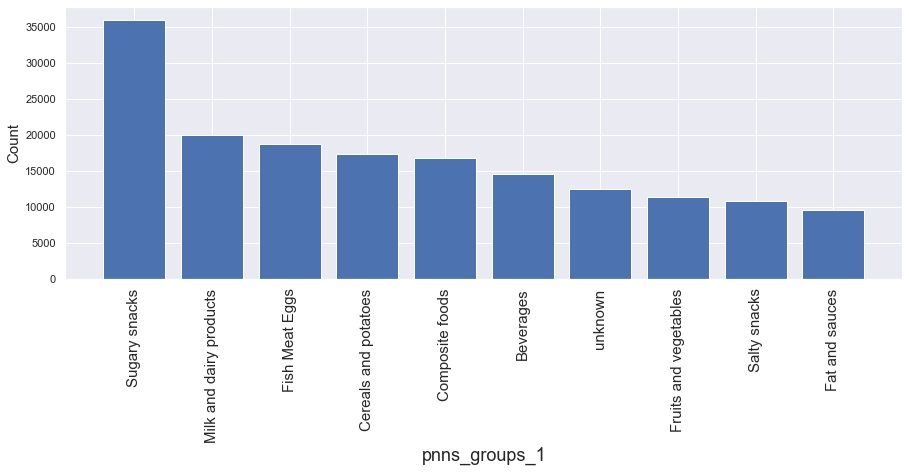

In [152]:
# Count the number of rows per pnns group_1
count_pnns_1 = openfoodfacts['pnns_groups_1'].value_counts().to_dict()

plt.figure(figsize=(15,5))
plt.bar(count_pnns_1.keys(), count_pnns_1.values())
plt.xticks(fontsize=15, rotation=90)
plt.xlabel('pnns_groups_1', fontsize=18)
plt.ylabel("Count", fontsize=15);

In [153]:
# Same process for 'pnns_groups_2'
openfoodfacts['pnns_groups_2'].value_counts().to_dict()
# -> 12515 products have no category pnns_groups_2

{'Biscuits and cakes': 16043,
 'One-dish meals': 13281,
 'Sweets': 12634,
 'unknown': 12518,
 'Processed meat': 8723,
 'Cheese': 7763,
 'Cereals': 7315,
 'Dressings and sauces': 7247,
 'Milk and yogurt': 6407,
 'Vegetables': 5682,
 'Sweetened beverages': 5563,
 'Chocolate products': 5465,
 'Fish and seafood': 5365,
 'Salty and fatty products': 4931,
 'Appetizers': 4431,
 'Bread': 4200,
 'Meat': 3694,
 'Breakfast cereals': 3291,
 'Dairy desserts': 3131,
 'Fruits': 2991,
 'Fruit juices': 2775,
 'Ice cream': 2647,
 'Unsweetened beverages': 2326,
 'Fats': 2313,
 'Pizza pies and quiches': 2152,
 'Artificially sweetened beverages': 1865,
 'Pastries': 1809,
 'Legumes': 1606,
 'Nuts': 1520,
 'Dried fruits': 1469,
 'Sandwiches': 1329,
 'Soups': 1269,
 'Plant-based milk substitutes': 1134,
 'Potatoes': 993,
 'Waters and flavored waters': 637,
 'Eggs': 490,
 'Offals': 438,
 'Fruit nectars': 114,
 'Teas and herbal teas and coffees': 106,
 'Alcoholic beverages': 28}

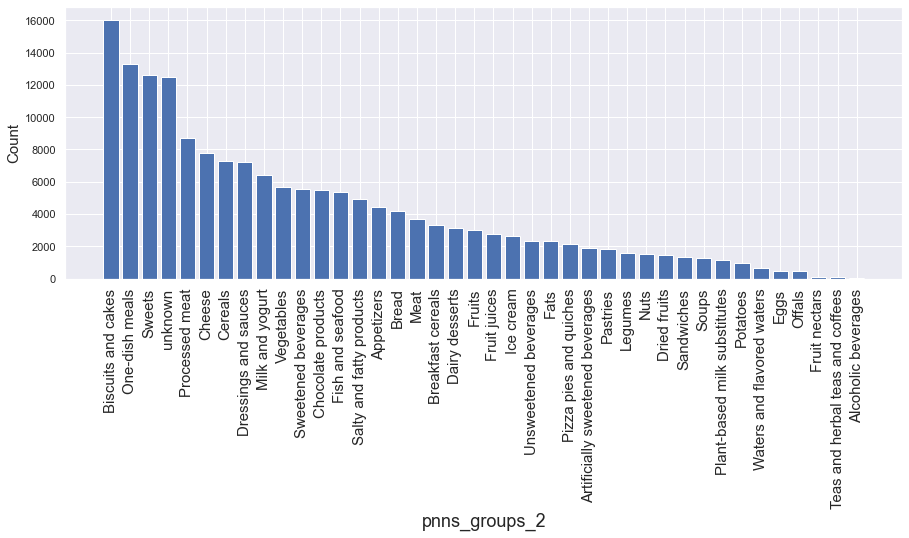

In [154]:
# Count the number of rows per pnns group_2
count_pnns_2 = openfoodfacts['pnns_groups_2'].value_counts().to_dict()

plt.figure(figsize=(15,5))
plt.bar(count_pnns_2.keys(), count_pnns_2.values())
plt.xticks(fontsize=15, rotation=90)
plt.xlabel('pnns_groups_2', fontsize=18)
plt.ylabel("Count", fontsize=15);

In [155]:
# Change alcoholic to unalcoholiv beverages
openfoodfacts = alcoholic_to_unalcoholic(openfoodfacts)

In [156]:
# Creation of a list containing the categories pnns_groups_1
# (without 'unknown' category)
pnns_1 = openfoodfacts["pnns_groups_1"].unique().tolist()
pnns_1.remove('unknown')
pnns_1

['Cereals and potatoes',
 'Salty snacks',
 'Milk and dairy products',
 'Sugary snacks',
 'Composite foods',
 'Fruits and vegetables',
 'Fish Meat Eggs',
 'Fat and sauces',
 'Beverages']

In [157]:
# Creation of a list containing the categories pnns_groups_2
# (without 'unknown' category)
pnns_2 = openfoodfacts["pnns_groups_2"].unique().tolist()
pnns_2.remove('unknown')

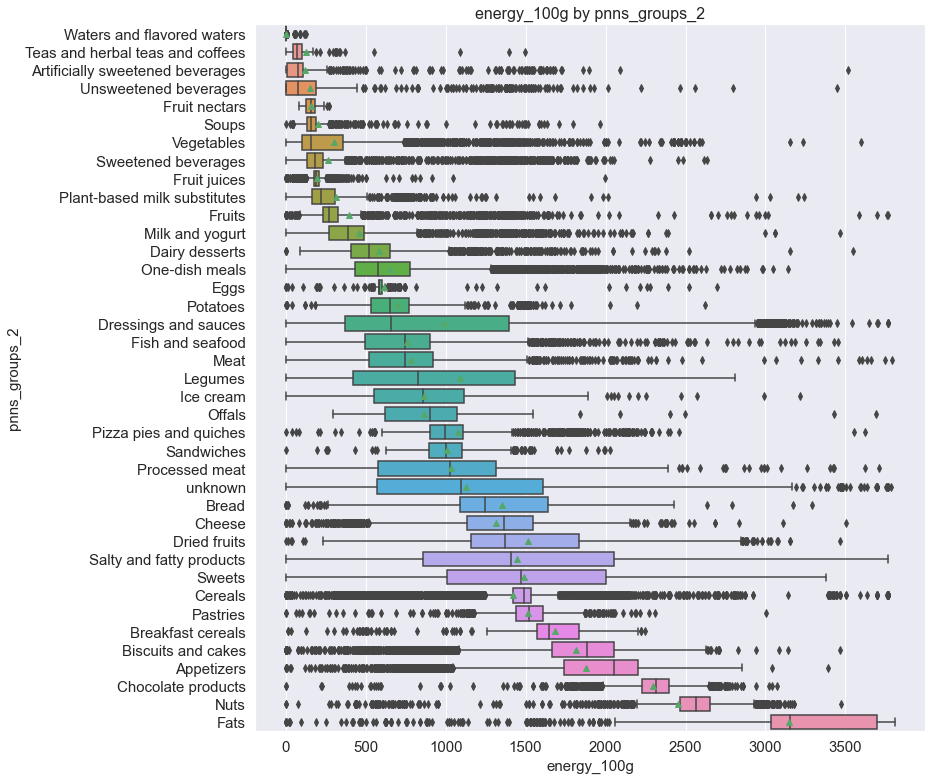

In [158]:
# Boxplot of 'energy_100g' by pnns_2
display_boxplot_sorted_median(df=openfoodfacts, x="energy_100g", y="pnns_groups_2")

**We want to replace the 'unknown' categories of columns "pnns_groups_1" and "pnns_groups_2" by categories thanks to the categories "main_category_fr" and/or "categories_fr"**

In [159]:
# Creation of a dictionary with keys = pnns group 1 and values = pnns group 2
pnns_2_by_pnns_1 = {
    p.replace(" ", "_").replace("-", "_").lower() + "_pnns_2":
    (openfoodfacts.loc[openfoodfacts["pnns_groups_1"] == p]["pnns_groups_2"].unique().tolist())
    for p in pnns_1}

In [160]:
# Display the dictionary 'pnns_2_by_pnns_1'
pnns_2_by_pnns_1

{'cereals_and_potatoes_pnns_2': ['Bread',
  'Breakfast cereals',
  'Potatoes',
  'Cereals',
  'Legumes'],
 'salty_snacks_pnns_2': ['Nuts', 'Salty and fatty products', 'Appetizers'],
 'milk_and_dairy_products_pnns_2': ['Cheese',
  'Dairy desserts',
  'Milk and yogurt',
  'Ice cream'],
 'sugary_snacks_pnns_2': ['Biscuits and cakes',
  'Sweets',
  'Chocolate products',
  'Pastries'],
 'composite_foods_pnns_2': ['One-dish meals',
  'Pizza pies and quiches',
  'Sandwiches'],
 'fruits_and_vegetables_pnns_2': ['Vegetables',
  'Dried fruits',
  'Fruits',
  'Soups'],
 'fish_meat_eggs_pnns_2': ['Processed meat',
  'Eggs',
  'Meat',
  'Offals',
  'Fish and seafood'],
 'fat_and_sauces_pnns_2': ['Dressings and sauces', 'Fats'],
 'beverages_pnns_2': ['Unsweetened beverages',
  'Sweetened beverages',
  'Fruit juices',
  'Artificially sweetened beverages',
  'Fruit nectars',
  'Plant-based milk substitutes',
  'Waters and flavored waters',
  'Teas and herbal teas and coffees']}

In [161]:
# Creation of a dictionary that groups main_categories_fr into pnns 2 groups
main_category_by_pnns_2 = {
    p.replace(" ", "_").replace("-", "_").lower() + "_main_category":
    (openfoodfacts.loc[openfoodfacts["pnns_groups_2"] == p]["main_category_fr"].unique().tolist())
    for p in pnns_2}

In [162]:
# Create a dataframe containing only 'unknown' rows
# for pnns_groups_1 and pnns_groups_2 columns
openfoodfacts_unknown = openfoodfacts.loc[openfoodfacts['pnns_groups_2'] == 'unknown']

# Reset index
openfoodfacts_unknown = openfoodfacts_unknown.reset_index(drop=False)
openfoodfacts_unknown.shape

(12518, 23)

In [163]:
# replace 'unknown' with pnns_groups_2
start = time.process_time()

openfoodfacts_unknown = replace_unknown_by_pnns_2(openfoodfacts_unknown)

end = time.process_time()
print(f"{end - start} seconds")

0.875 seconds


In [164]:
# Check the number of remaining 'unknown' category
openfoodfacts_unknown['pnns_groups_2'].value_counts().to_dict()

{'unknown': 4742,
 'One-dish meals': 1496,
 'Sweets': 1267,
 'Biscuits and cakes': 923,
 'Nuts': 479,
 'Cereals': 473,
 'Cheese': 337,
 'Vegetables': 333,
 'Unsweetened beverages': 276,
 'Dairy desserts': 275,
 'Sweetened beverages': 257,
 'Processed meat': 210,
 'Milk and yogurt': 175,
 'Dressings and sauces': 174,
 'Fish and seafood': 140,
 'Bread': 132,
 'Pizza pies and quiches': 123,
 'Ice cream': 122,
 'Salty and fatty products': 91,
 'Legumes': 81,
 'Meat': 69,
 'Fruits': 69,
 'Dried fruits': 63,
 'Chocolate products': 50,
 'Appetizers': 35,
 'Potatoes': 28,
 'Fats': 25,
 'Breakfast cereals': 21,
 'Pastries': 17,
 'Fruit juices': 13,
 'Sandwiches': 9,
 'Artificially sweetened beverages': 4,
 'Plant-based milk substitutes': 4,
 'Eggs': 3,
 'Soups': 1,
 'Offals': 1}

- **There are still 4740 'unknown'**

In [165]:
# replace 'unknown' with pnns_groups_1
start = time.process_time()

openfoodfacts_unknown = replace_unknown_by_pnns_1(openfoodfacts_unknown)

end = time.process_time()
print(f"{end - start} seconds")

0.625 seconds


In [166]:
# Check the number of remaining 'unknown' category
openfoodfacts_unknown['pnns_groups_1'].value_counts().to_dict()

{'unknown': 4742,
 'Sugary snacks': 2257,
 'Composite foods': 1628,
 'Milk and dairy products': 909,
 'Cereals and potatoes': 735,
 'Salty snacks': 605,
 'Beverages': 554,
 'Fruits and vegetables': 466,
 'Fish Meat Eggs': 423,
 'Fat and sauces': 199}

In [167]:
# Reinsert the dataframe with the unknowns reassigned
# to the dataframe without the unknowns

# Get names of indexes for which column Stock has value 'unknown' in openfoodfacts
indexNames = openfoodfacts.loc[openfoodfacts['pnns_groups_1'] == 'unknown' ].index
# Delete these row indexes from dataFrame
openfoodfacts = openfoodfacts.drop(indexNames)
# Get names of indexes for which column Stock has value 'unknown' in openfoodfacts_unknown
indexNames = openfoodfacts_unknown.loc[
    openfoodfacts_unknown['pnns_groups_1'] == 'unknown' 
].index
# Delete these row indexes from dataFrame
openfoodfacts_unknown = openfoodfacts_unknown.drop(indexNames)

In [168]:
# Merge dataframes
openfoodfacts = pd.concat(
    [openfoodfacts, openfoodfacts_unknown], 
    ignore_index=True
)
openfoodfacts = openfoodfacts.drop(['index'], axis=1)

### Replace the NaNs by the medians of the groups pnns_2

In [173]:
# Create a list of columns to impute
columns_median = [
    'energy_100g', 'fat_100g', 'saturated_fat_100g', 'carbohydrates_100g',
    'sugars_100g', 'proteins_100g', 'salt_100g', 'fiber_100g',
    'fruits_vegetables_nuts_estimate_from_ingredients_100g'
]

In [174]:
# Replace NaN values of the different nutrition or energy columns
# by the median of each column by pnns_group_2
openfoodfacts = replace_NaN_by_median_pnns_2(openfoodfacts)

In [176]:
# Check missing values
openfoodfacts.isna().mean()

code                                                     0.0
url                                                      0.0
image_url                                                0.0
product_name                                             0.0
categories_fr                                            0.0
countries_fr                                             0.0
additives_n                                              0.0
nutriscore_score                                         0.0
nutriscore_grade                                         0.0
nova_group                                               0.0
pnns_groups_1                                            0.0
pnns_groups_2                                            0.0
main_category_fr                                         0.0
energy_100g                                              0.0
fat_100g                                                 0.0
saturated_fat_100g                                       0.0
carbohydrates_100g      

In [178]:
# Save the final cleaned dataframe for analysis
openfoodfacts.to_csv(
    'openfoodfacts_cleaned.csv',
    sep='\t',
    encoding='utf-8',
    index=False
)